In [1]:
## Tunes depth profiles of Korolev to each other using dynamic time warping algorithm
## Depth profiles should be .csv files located in ./korolev
## Plots tunings and computes cross-correlation
## Tests XC value against XC's from tunings to random profiles

In [2]:
#Import packages
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams.update({'figure.max_open_warning': 0})
import pandas as pd
import glob
from radarfuncs import *
from DTWfuncs import *
from lmfit.models import SkewedGaussianModel

In [3]:
#Import csv files
csv_import = glob.glob("korolev/*zoom.csv")
csv_import = sorted(csv_import, key=lambda x: x[-9])

column_names = ['depth', 'value']
x_list = []
y_list = []
fit_list = []

#load data and put into lists
for i in csv_import:
    csv = pd.read_csv(i, names=column_names, skiprows=2) #skips headers
    
    x = csv.depth.to_list()
    y = csv.value.to_list()
    
    peak = y.index(max(y[0:50])) #finds surface return
    
    x = x[peak+5:]
    y = y[peak+5:]
    
    #convert pixels to meters
    #x = p2m_waterice(x)
    
    x_list.append(x)
    y_list.append(y)
    
    ##compute line to fit synthetic data to
    # Skewed Gaussian fit
    model = SkewedGaussianModel()
    params = model.make_params(amplitude=(max(y)), center=min(x)+20, sigma=20, gamma=1.5)
    result = model.fit(y, params, x=x)
    fit = result.best_fit +np.mean(y[-150:]) # prevents fit from damping out all of the noise on right-handed side
    
    fit_list.append(fit)
    
print(csv_import)


['korolev/S_02186601_1zoom.csv', 'korolev/S_04051801_2zoom.csv', 'korolev/S_00554201_3zoom.csv', 'korolev/S_00883101_4zoom.csv', 'korolev/S_01690101_5zoom.csv']


KeyboardInterrupt: 

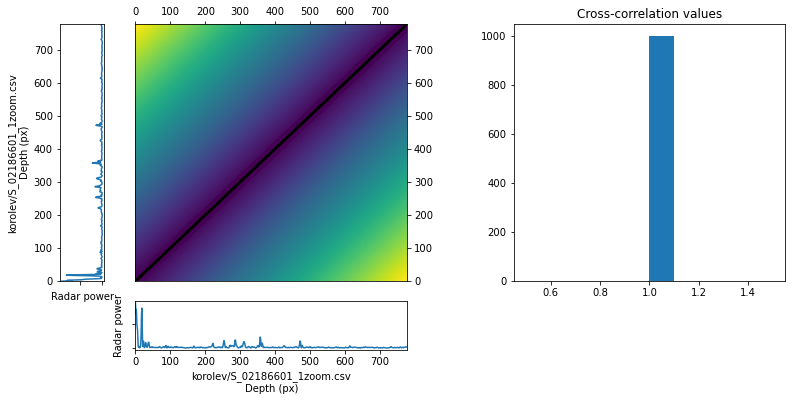

In [4]:
#Use DTW to tune each profile to the other profiles
#plot results, produce XC


for i in range(len(csv_import)):
    prof1 = csv_import[i]
    d1 = x_list[i]
    v1 = y_list[i]
    #fit1 = fit_list[i] don't need until montecarlo
    
    for j in range(len(csv_import)):
        prof2 = csv_import[j]
        d2 = x_list[j]
        v2 = y_list[j]
            
        xtune, XC, tstd, dt, W, D = dtw_mars(v1,v2)
        #print(W)
        np.savetxt('cost_'+str(i)+str(j)+'.csv', D, delimiter=',')
        
        #Run MonteCarlo simulation to assess quality of tunings
        #A strong match is when real XC is nigher than 90% of all XCs from tunings to random profiles

        XC_rs = [] #holds cross correlation values for 1000 random profiles
        syn = []
        #W_rs = []

        for a in range(1000):
            r=ar1(x,y,fit) #this creates a random synthetic record with similar properties
            syn.append(r)
            xtune_r, XC_r, tstd_r, dt_r, W_r, D_r = dtw_mars(v1,r)
            XC_rs.append(XC_r)
            #W_rs.append(W_r)
        
        # Set up the axes with gridspec
        fig = plt.figure(figsize=(13,6))
        grid = plt.GridSpec(5, 10, hspace=0.4, wspace=0.7)
        main = fig.add_subplot(grid[:-1, 1:5])
        y_prof = fig.add_subplot(grid[:-1, 0], xticklabels=[], sharey=main)
        x_prof = fig.add_subplot(grid[-1, 1:5], yticklabels=[], sharex=main)
        hist = fig.add_subplot(grid[:-1,6:])

        # DTW min path on main
        main.pcolor(D)
        main.plot([0,len(v1)-1], [0,len(xtune)-1],'w--', linewidth=2)
        main.plot(W[:,1], W[:,0],'k-', linewidth=3)
        main.xaxis.tick_top()
        main.yaxis.tick_right()

        # x profile -- what gets tuned
        xax= np.subtract(d2,d2[0])
        x_prof.plot(xax, v2)
        x_prof.set_xlabel(prof2 + "\nDepth (px)")
        x_prof.set_ylabel("Radar power")

        #y profile -- fixed
        yax = np.subtract(d1,d1[0])
        y_prof.plot(np.multiply(-1,v1),yax)
        y_prof.set_ylabel(prof1 + "\nDepth (px)")
        y_prof.set_xlabel("Radar power")
    
        # histogram of XC values
        hist.hist(XC_rs) #bins = n_bins
        hist.set_title("Cross-correlation values: n="+str(len(XC_rs)))
        
        print("XC of "+prof1+" and "+prof2+": "+str(XC))



In [ ]:
fig = plt.figure(figsize=(13,6))
grid = plt.GridSpec(5, 10, hspace=0.4, wspace=0.7)
main = fig.add_subplot(grid[:-1, 1:5])
y_prof = fig.add_subplot(grid[:-1, 0], xticklabels=[], sharey=main)
x_prof = fig.add_subplot(grid[-1, 1:5], yticklabels=[], sharex=main)
hist = fig.add_subplot(grid[:-1,6:])